# 4. Extract Transforms Use Cases - VL Example

In this notebook, I will show some use cases for extracting out the [transformations](https://vega.github.io/vega-lite/docs/transform.html) in a Vega Lite spec and computing them in the database instead of on the client. 

We use the same examples that the VL team came up with to demo this functionality: https://vega.github.io/vega-lite-transforms2sql/


In [1]:
import altair as alt
import ibis
import omnisci_renderer

In [2]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

Let's recreate the first example, counting the carrier names:

In [8]:
conn = ibis.mapd.connect(
    host='metis.mapd.com', user='mapd', password='HyperInteractive',
    port=443, database='mapd', protocol= 'https'
)
t = conn.table("flights_donotmodify")

Using the `display_chart` function we can get a debugging view of how we render this chart.

We start by putting it through Altair's default pipeline and we see we get a chart without all the data, because we are capped at retrieving all the rows.

Then we can see the Vega Lite JSON after extracting the transformings, then we can plot that directly. Still not all the data, b/c we are still doing transformations (counting in this case) client side.

Finally, we can move the transformations to the backend, by turning them into ibis expressions and getting the transformed data. This should show the right plot.

NOTE: This example is  currently broken, depending on https://github.com/ibis-project/ibis/pull/1675

'json'

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


'default'

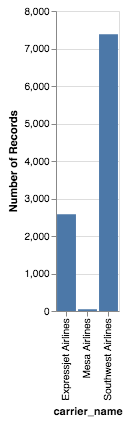

'extract-json'

<IPython.core.display.JSON object>

'extract'

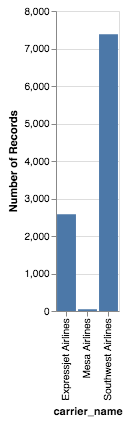

'extract-ibis'

In [12]:
c = alt.Chart(t[t.carrier_name]).mark_bar().encode(
    x='carrier_name',
    y='count()'
)
omnisci_renderer.display_chart(c)

'json'

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


'default'

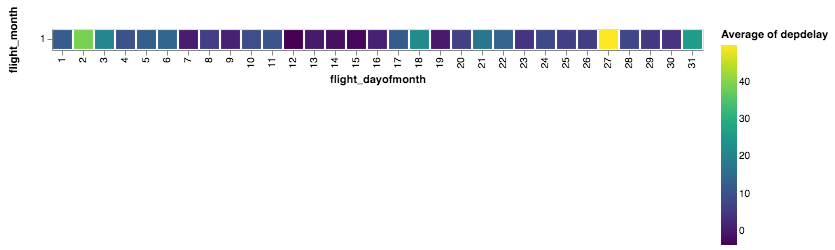

'extract-json'

<IPython.core.display.JSON object>

'extract'

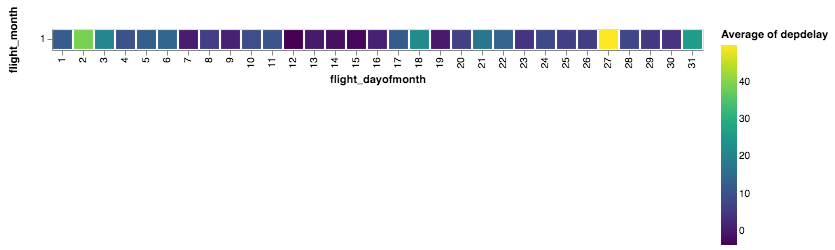

'extract-ibis'

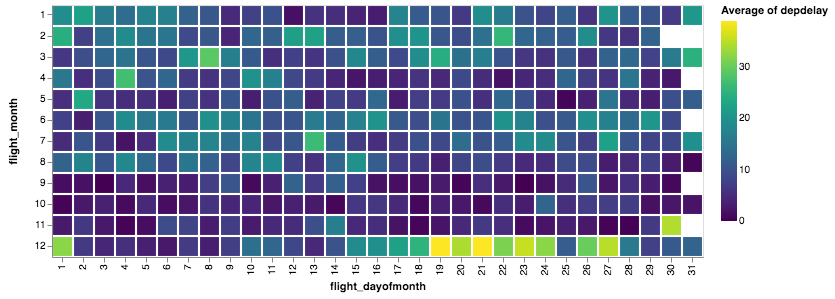

In [10]:
alt.renderers.enable('default')

c = alt.Chart(t[t.flight_dayofmonth, t.flight_month, t.depdelay]).mark_rect().encode(
    x='flight_dayofmonth:O',
    y='flight_month:O',
    color='average(depdelay)'
)
omnisci_renderer.display_chart(c)